In [1]:
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
import osmnx as ox
from shapely.geometry import Point
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the GeoJSON file as a JSON object
with open('df_nearby_businesses.geojson', 'r') as f:
    geojson_data = json.load(f)

# Extract the 'Business Type' field from the features
business_types = [feature['properties'].get('Business Type', []) for feature in geojson_data['features']]

# Load the GeoJSON file into a GeoDataFrame (without the problematic field)
df_nearby_restaurant_businesses = gpd.read_file('df_nearby_businesses.geojson', ignore_geometry=False)

Skipping field Business Type: unsupported OGR type: 5


In [3]:
chicken_rep_lagos_branch = gpd.read_file('chicken_rep_lagos_branch.geojson')
df_nearby_poi = gpd.read_file('df_nearby_poi.geojson')

In [4]:
df_nearby_poi.columns

Index(['distance', 'branch_location', 'branch_latitude', 'branch_longitude',
       'name', 'amenity', 'shop', 'building', 'landuse', 'office', 'brand',
       'operator', 'opening_hours', 'building:levels', 'tourism', 'healthcare',
       'drive_through', 'parking', 'addr:street', 'addr:city', 'addr:postcode',
       'wheelchair', 'internet_access', 'outdoor_seating', 'amenity_category',
       'geometry'],
      dtype='object')

In [5]:
df_nearby_poi.amenity.unique()

array(['bank', 'school', 'hospital', 'marketplace', None, 'clinic',
       'events_venue', 'fuel', 'atm', 'police', 'post_office',
       'university', 'community_centre', 'place_of_worship', 'cafe'],
      dtype=object)

In [6]:
df_nearby_poi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   distance          2685 non-null   float64 
 1   branch_location   2685 non-null   object  
 2   branch_latitude   2685 non-null   float64 
 3   branch_longitude  2685 non-null   float64 
 4   name              1798 non-null   object  
 5   amenity           1295 non-null   object  
 6   shop              154 non-null    object  
 7   building          673 non-null    object  
 8   landuse           911 non-null    object  
 9   office            130 non-null    object  
 10  brand             164 non-null    object  
 11  operator          303 non-null    object  
 12  opening_hours     58 non-null     object  
 13  building:levels   87 non-null     object  
 14  tourism           91 non-null     object  
 15  healthcare        72 non-null     object  
 16  drive_through   

In [7]:
df_nearby_restaurant_businesses.columns

Index(['Name', 'Latitude', 'Longitude', 'Rating', 'Location', 'geometry'], dtype='object')

In [8]:
chicken_rep_lagos_branch.columns

Index(['Location', 'Address', 'Latitude', 'Longitude', 'LGA',
       'distance_to_road_m', 'node_degree', 'road_density_500m', 'geometry'],
      dtype='object')

In [49]:
chicken_rep_lagos_branch.LGA.value_counts()

LGA
Eti-Osa         12
Alimosho         6
Ikeja            6
Kosofe           6
Mainland         5
Surulere         4
Shomolu          4
Oshodi/Isolo     4
Ikorodu          3
Amuwo Odofin     1
Apapa            1
Mushin           1
Ibeju-Lekki      1
Name: count, dtype: int64

In [9]:
df_nearby_restaurant_businesses = df_nearby_restaurant_businesses[~df_nearby_restaurant_businesses['Name'].str.contains('Chicken Republic', case=False)]

In [10]:
df_nearby_restaurant_businesses.Name.value_counts().head(20)

Name
Domino's Pizza                         12
Marhaba International Restaurant        9
KFC                                     8
De Tastee Fried Chicken                 8
Mama Cass Restaurant                    5
Mr Biggs                                5
Bukka Hut                               5
01SHAWARMA Akerele                      4
Best Western Plus Lagos Ikeja Hotel     4
Pancake Hub                             4
Good Heart Restaurant                   4
Aerol Hotel                             4
Choppies fastfoods                      4
Calabar Kitchen                         4
Funky B&T                               4
4 Seasons Hotel                         4
Hot Flavor Barbecue                     4
Hungry Tigers-La Belle Cuisine          4
BUHKA EXPRESS                           4
Sweet Sensation Confectionery           4
Name: count, dtype: int64

In [11]:
# Read the CSV file into a DataFrame
lagos_settlement_df = pd.read_csv('Lagos_settlement_extents.csv')

In [12]:
lagos_settlement_df.columns

Index(['country', 'iso3', 'building_count', 'building_area', 'type',
       'probability', 'date', 'source', 'mgrs_code', 'geometry'],
      dtype='object')

In [13]:
lagos_settlement_df.head()

,country,iso3,building_count,building_area,type,probability,date,source,mgrs_code,geometry
0,Nigeria,NGA,1,54.869418,Hamlet,0.937261,2024,CIESIN,31NDH7305_1,POLYGON ((2.7607517640000196 6.382043191000037...
1,Nigeria,NGA,14,1690.240412,Hamlet,0.991675,2024,CIESIN,31NDH7605_1,POLYGON ((2.7900977480000506 6.386724980000054...
2,Nigeria,NGA,8,1069.335359,Hamlet,0.999990,2024,CIESIN,31NDH7606_1,POLYGON ((2.7884310810000557 6.385891647000051...
3,Nigeria,NGA,4,167.085552,Hamlet,0.629821,2024,CIESIN,31NDH7705_1,POLYGON ((2.7937492690000454 6.386576551000076...
4,Nigeria,NGA,12,886.057948,Hamlet,0.999990,2024,CIESIN,31NDH7706_1,"POLYGON ((2.795626352000056 6.387294011000051,..."


In [14]:
poi_of_interest = ['bank', 'school', 'hospital', 'marketplace','police','atm','fuel','clinic','university','community_centre','post_office']
filtered_poi_gdf = df_nearby_poi[df_nearby_poi['amenity'].isin(poi_of_interest)].copy()

In [15]:
banks_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'bank']
school_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'school']
hospital_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'hospital']
marketplace_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'marketplace']
police_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'police']
atm_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'atm']
fuel_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'fuel']
university_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'university']
clinic_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'clinic']
community_centre_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'community_centre']
post_office_gdf = filtered_poi_gdf[filtered_poi_gdf['amenity'] == 'post_office']



def nearest_distance_to_poi(chicken_loc, poi_gdf):
    """Calculates the distance to the nearest POI for each chicken location."""
    distances = []
    for chicken_geom in chicken_loc.geometry:
        min_dist = float('inf')
        for poi_geom in poi_gdf.geometry:
            dist = chicken_geom.distance(poi_geom)
            min_dist = min(min_dist, dist)
        distances.append(min_dist)
    return distances

chicken_rep_lagos_branch['distance_to_nearest_bank'] = nearest_distance_to_poi(chicken_rep_lagos_branch, banks_gdf)
chicken_rep_lagos_branch['distance_to_nearest_school'] = nearest_distance_to_poi(chicken_rep_lagos_branch, school_gdf)
chicken_rep_lagos_branch['distance_to_nearest_hospital'] = nearest_distance_to_poi(chicken_rep_lagos_branch, hospital_gdf)
chicken_rep_lagos_branch['distance_to_nearest_marketplace'] = nearest_distance_to_poi(chicken_rep_lagos_branch, marketplace_gdf)
chicken_rep_lagos_branch['distance_to_nearest_police'] = nearest_distance_to_poi(chicken_rep_lagos_branch, police_gdf)
chicken_rep_lagos_branch['distance_to_nearest_atm'] = nearest_distance_to_poi(chicken_rep_lagos_branch, atm_gdf)
chicken_rep_lagos_branch['distance_to_nearest_fuel'] = nearest_distance_to_poi(chicken_rep_lagos_branch, fuel_gdf)
chicken_rep_lagos_branch['distance_to_nearest_university'] = nearest_distance_to_poi(chicken_rep_lagos_branch, university_gdf)
chicken_rep_lagos_branch['distance_to_nearest_clinic'] = nearest_distance_to_poi(chicken_rep_lagos_branch, clinic_gdf)
chicken_rep_lagos_branch['distance_to_nearest_community_centre'] = nearest_distance_to_poi(chicken_rep_lagos_branch, community_centre_gdf)
chicken_rep_lagos_branch['distance_to_nearest_post_office'] = nearest_distance_to_poi(chicken_rep_lagos_branch, post_office_gdf)

In [16]:
chicken_rep_lagos_branch[['distance_to_nearest_bank']].describe()

,distance_to_nearest_bank
count,54.000000
mean,0.011121
std,0.009464
min,0.000000
25%,0.004760
50%,0.010323
75%,0.014084
max,0.057778


In [17]:
# Count the number of rows where distance_to_nearest_bank is 0
count_zero_distance = chicken_rep_lagos_branch[chicken_rep_lagos_branch['distance_to_nearest_bank'] == 0].shape[0]

print(f"Number of locations not near banks (distance = 0): {count_zero_distance}")

Number of locations not near banks (distance = 0): 1


In [18]:
chicken_rep_lagos_branch['distance_to_nearest_school'].describe()

count    54.000000
mean      0.007456
std       0.005939
min       0.000000
25%       0.003734
50%       0.005738
75%       0.009763
max       0.029698
Name: distance_to_nearest_school, dtype: float64

In [19]:
chicken_rep_lagos_branch['distance_to_nearest_hospital'].describe()

count    54.000000
mean      0.013733
std       0.017343
min       0.000390
25%       0.003500
50%       0.006435
75%       0.016213
max       0.080325
Name: distance_to_nearest_hospital, dtype: float64

In [20]:
chicken_rep_lagos_branch['distance_to_nearest_marketplace'].describe()

count    54.000000
mean      0.025509
std       0.027133
min       0.001125
25%       0.011263
50%       0.017408
75%       0.027945
max       0.153873
Name: distance_to_nearest_marketplace, dtype: float64

In [21]:
chicken_rep_lagos_branch['distance_to_nearest_police'].describe()

count    54.000000
mean      0.117369
std       0.082733
min       0.004854
25%       0.056800
50%       0.100643
75%       0.181426
max       0.373862
Name: distance_to_nearest_police, dtype: float64

In [22]:
chicken_rep_lagos_branch['distance_to_nearest_atm'].describe()

count    54.000000
mean      0.039334
std       0.032492
min       0.005298
25%       0.017780
50%       0.029207
75%       0.052179
max       0.171081
Name: distance_to_nearest_atm, dtype: float64

In [23]:
chicken_rep_lagos_branch['distance_to_nearest_fuel'].describe()

count    54.000000
mean      0.057248
std       0.043802
min       0.000000
25%       0.021388
50%       0.059369
75%       0.081158
max       0.185861
Name: distance_to_nearest_fuel, dtype: float64

In [24]:
# Count the number of rows where distance_to_nearest_bank is 0
count_zero_distance = chicken_rep_lagos_branch[chicken_rep_lagos_branch['distance_to_nearest_fuel'] == 0].shape[0]

print(f"Number of locations not near atm (distance = 0): {count_zero_distance}")

Number of locations not near atm (distance = 0): 1


In [25]:
chicken_rep_lagos_branch['distance_to_nearest_university'].describe()

count    54.000000
mean      0.063235
std       0.058150
min       0.003028
25%       0.024755
50%       0.044206
75%       0.079127
max       0.276110
Name: distance_to_nearest_university, dtype: float64

In [26]:
chicken_rep_lagos_branch['distance_to_nearest_clinic'].describe()

count    54.000000
mean      0.034106
std       0.021020
min       0.000532
25%       0.016945
50%       0.029555
75%       0.048144
max       0.085460
Name: distance_to_nearest_clinic, dtype: float64

In [27]:
chicken_rep_lagos_branch['distance_to_nearest_community_centre'].describe()

count    54.000000
mean      0.141176
std       0.065216
min       0.004148
25%       0.092936
50%       0.142741
75%       0.188790
max       0.285032
Name: distance_to_nearest_community_centre, dtype: float64

In [28]:
chicken_rep_lagos_branch['distance_to_nearest_post_office'].describe()

count    54.000000
mean      0.078952
std       0.055199
min       0.002251
25%       0.037710
50%       0.072388
75%       0.097311
max       0.290198
Name: distance_to_nearest_post_office, dtype: float64

In [29]:
def nearest_distance_to_restaurants(chicken_loc, restaurant_gdf):
    """Calculates the distance to the nearest restaurant for each chicken location."""
    distances = []
    for chicken_geom in chicken_loc.geometry:
        min_dist = float('inf')
        for restaurant_geom in restaurant_gdf.geometry:
            dist = chicken_geom.distance(restaurant_geom)
            min_dist = min(min_dist, dist)
        distances.append(min_dist)
    return distances

chicken_rep_lagos_branch['distance_to_nearest_restaurant'] = nearest_distance_to_restaurants(chicken_rep_lagos_branch, df_nearby_restaurant_businesses)

chicken_rep_lagos_branch['distance_to_nearest_restaurant'].describe()

count    54.000000
mean      0.001119
std       0.001744
min       0.000000
25%       0.000181
50%       0.000521
75%       0.001235
max       0.007940
Name: distance_to_nearest_restaurant, dtype: float64

In [30]:
# Count the number of rows where distance_to_nearest_restaurant is 0
count_zero_distance_restaurant = chicken_rep_lagos_branch[chicken_rep_lagos_branch['distance_to_nearest_restaurant'] == 0].shape[0]

print(f"Number of locations with zero distance to the nearest restaurant: {count_zero_distance_restaurant}")

Number of locations with zero distance to the nearest restaurant: 5


In [31]:
# 1. Road Network Analysis
# Descriptive Statistics
chicken_rep_lagos_branch[['distance_to_road_m', 'node_degree', 'road_density_500m']].describe()

,distance_to_road_m,node_degree,road_density_500m
count,54.000000,54.000000,5.400000e+01
mean,48.733660,4.666667,3.215027e+07
std,132.551617,1.479419,1.074587e-08
min,0.028947,2.000000,3.215027e+07
25%,7.040354,4.000000,3.215027e+07
50%,12.825395,4.000000,3.215027e+07
75%,29.593069,6.000000,3.215027e+07
max,768.638985,8.000000,3.215027e+07


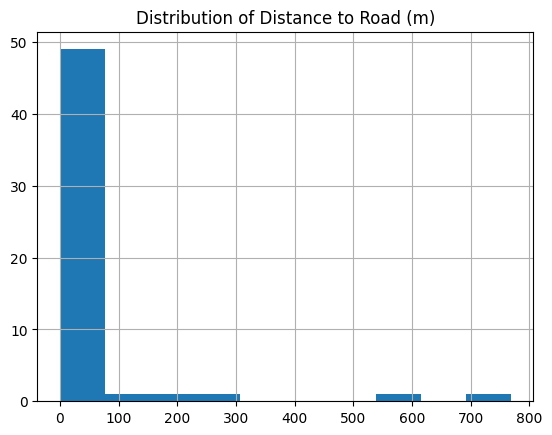

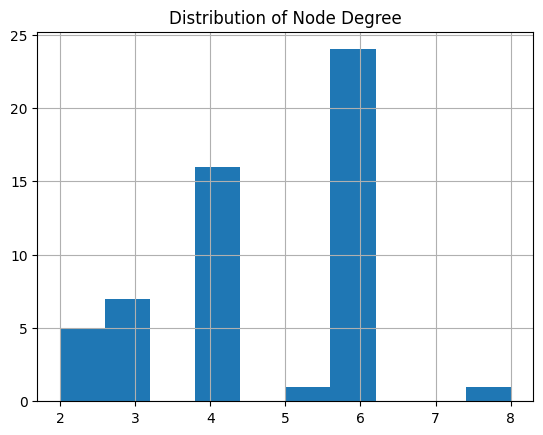

In [32]:
# Visualizations (Histograms)
chicken_rep_lagos_branch['distance_to_road_m'].hist()
plt.title("Distribution of Distance to Road (m)")
plt.show()

chicken_rep_lagos_branch['node_degree'].hist()
plt.title("Distribution of Node Degree")
plt.show()

In [33]:
chicken_rep_lagos_branch['road_density_500m'].unique()

array([32150274.0629627, 32150274.0629627])

In [34]:
# Correlation Analysis
correlation_matrix = chicken_rep_lagos_branch[['distance_to_road_m', 'node_degree', 'road_density_500m']].corr()
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,distance_to_road_m,node_degree,road_density_500m
distance_to_road_m,1.000000,-0.306814,0.227931
node_degree,-0.306814,1.000000,-0.093619
road_density_500m,0.227931,-0.093619,1.000000


In [35]:
from shapely.wkt import loads

# Convert WKT strings to Shapely geometries
lagos_settlement_df['geometry'] = lagos_settlement_df['geometry'].apply(loads)

In [36]:
from shapely.geometry import Point

# Use the centroid of each polygon as the settlement location
geometry_settlement = [polygon.centroid for polygon in lagos_settlement_df['geometry']]

# Create the GeoDataFrame with centroids as geometry
lagos_settlement_gdf = gpd.GeoDataFrame(lagos_settlement_df, geometry=geometry_settlement, crs="EPSG:4326")

def nearest_distance_to_branch(settlement_loc, branch_gdf):
    """Calculates the distance to the nearest branch for each settlement location."""
    distances = []
    for settlement_geom in settlement_loc.geometry:
        min_dist = float('inf')
        for branch_geom in branch_gdf.geometry:
            dist = settlement_geom.distance(branch_geom)
            min_dist = min(min_dist, dist)
        distances.append(min_dist)
    return distances

# Calculate the distances to the nearest branch
lagos_settlement_gdf['distance_to_branch'] = nearest_distance_to_branch(lagos_settlement_gdf, chicken_rep_lagos_branch)

In [37]:
print(type(lagos_settlement_df['geometry'].iloc[0]))

<class 'shapely.geometry.polygon.Polygon'>


In [38]:
# analyze settlement data around the branches.
lagos_settlement_gdf[['distance_to_branch','building_count']].describe()

,distance_to_branch,building_count
count,1894.000000,1.894000e+03
mean,0.242608,2.049467e+03
std,0.155015,5.806549e+04
min,0.001677,1.000000e+00
25%,0.116038,1.000000e+00
50%,0.226097,3.000000e+00
75%,0.355229,1.075000e+01
max,0.639539,2.418775e+06


In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import Voronoi, voronoi_plot_2d

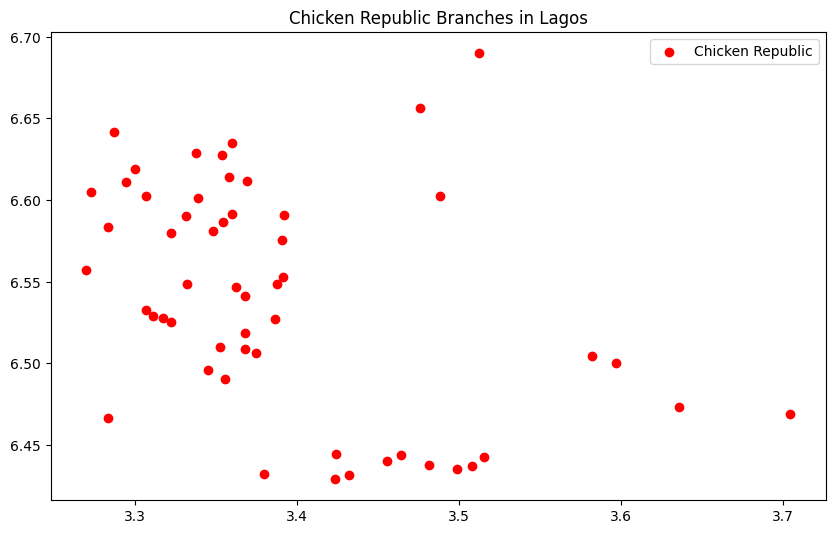

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
chicken_rep_lagos_branch.plot(ax=ax, color='red', marker='o', label='Chicken Republic')
plt.title("Chicken Republic Branches in Lagos")
plt.legend()
plt.show()

In [41]:
print("Longitude range:", chicken_rep_lagos_branch['Longitude'].min(), chicken_rep_lagos_branch['Longitude'].max())
print("Latitude range:", chicken_rep_lagos_branch['Latitude'].min(), chicken_rep_lagos_branch['Latitude'].max())

Longitude range: 3.2699058 3.704373
Latitude range: 6.4290982 6.689923


In [42]:
# Create a polygon representing the bounding box
from shapely.geometry import Polygon

In [43]:
# Use the extent of the data as the bounding box
bbox = [
    chicken_rep_lagos_branch['Longitude'].min(),
    chicken_rep_lagos_branch['Latitude'].min(),
    chicken_rep_lagos_branch['Longitude'].max(),
    chicken_rep_lagos_branch['Latitude'].max()
]
bounding_box = Polygon([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[1]],
    [bbox[2], bbox[3]],
    [bbox[0], bbox[3]],
])

In [44]:
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, shape
from shapely.ops import unary_union

# Generate the Voronoi diagram
coords = [(x, y) for x, y in zip(chicken_rep_lagos_branch.Longitude, chicken_rep_lagos_branch.Latitude)]
vor = Voronoi(coords)

# Convert Voronoi regions to Shapely polygons
vor_polygons = []
for region in vor.regions:
    if -1 not in region:  # Exclude regions with vertices at infinity
        polygon = Polygon([vor.vertices[i] for i in region])
        vor_polygons.append(polygon)

# Combine all Voronoi polygons into a single geometry
vor_union = unary_union(vor_polygons)

# Clip the Voronoi polygons to the bounding box
clipped_vor_polygons = vor_union.intersection(bounding_box)

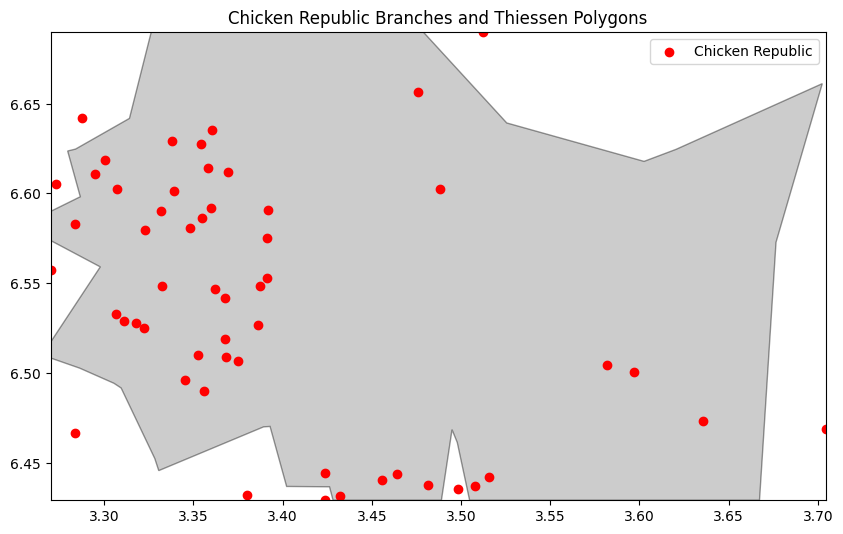

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the clipped Voronoi polygons
if clipped_vor_polygons.geom_type == 'Polygon':
    x, y = clipped_vor_polygons.exterior.xy
    ax.fill(x, y, alpha=0.4, fc='gray', edgecolor='black')
elif clipped_vor_polygons.geom_type == 'MultiPolygon':
    for polygon in clipped_vor_polygons.geoms:
        x, y = polygon.exterior.xy
        ax.fill(x, y, alpha=0.4, fc='gray', edgecolor='black')

# Plot the branch locations
chicken_rep_lagos_branch.plot(ax=ax, color='red', marker='o', label='Chicken Republic')

# Set plot limits to the bounding box
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

plt.title("Chicken Republic Branches and Thiessen Polygons")
plt.legend()
plt.show()

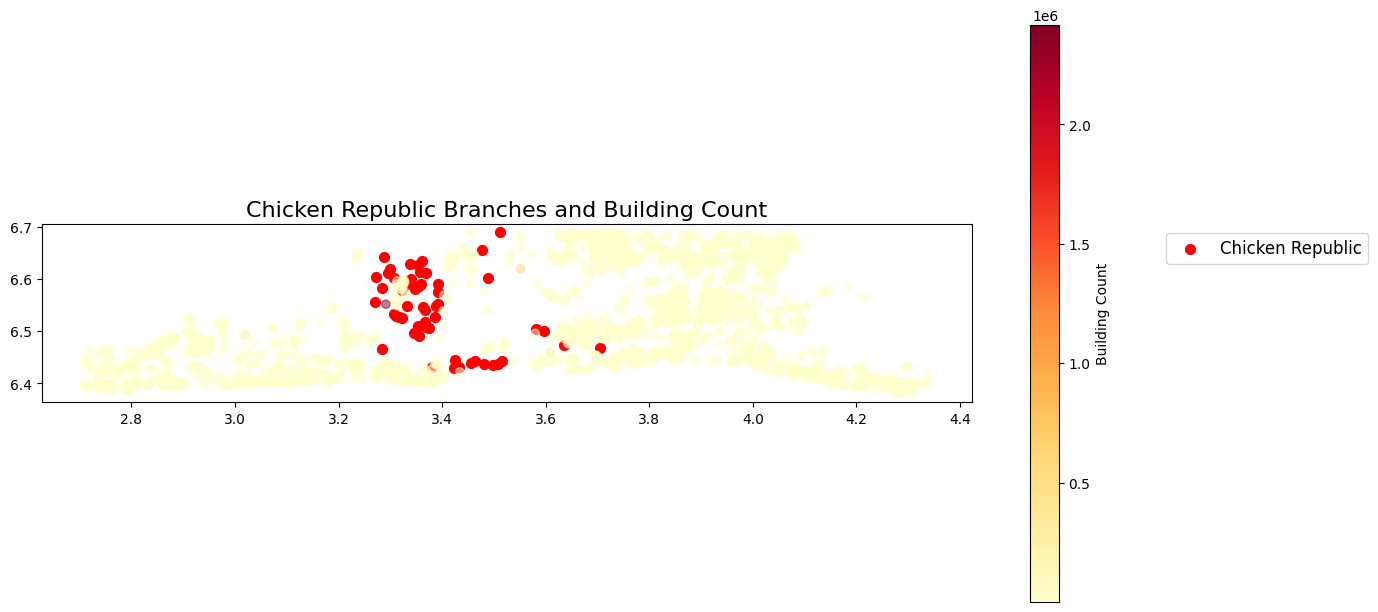

In [46]:
import matplotlib.pyplot as plt

# Create a larger figure
fig, ax = plt.subplots(figsize=(15, 15))  # Increase the figure size

# Plot Chicken Republic branches
chicken_rep_lagos_branch.plot(
    ax=ax,
    color='red',
    marker='o',
    label='Chicken Republic',
    markersize=50,  # Control marker size
)

# Plot settlements with building counts
lagos_settlement_gdf.plot(
    ax=ax,
    column='building_count',
    legend=True,
    alpha=0.5,
    cmap='YlOrRd',  # Use a colormap
    legend_kwds={
        'label': "Building Count",  # Add a title to the legend
        'orientation': "vertical",  # Vertical legend
        'shrink': 0.5,             # Reduce the size of the legend
    },
)

# Add title and adjust legend placement
plt.title("Chicken Republic Branches and Building Count", fontsize=16)
plt.legend(
    loc="upper left",            
    bbox_to_anchor=(1.2, 1),      # Move the legend slightly outside the plot
    fontsize=12                   # Adjust font size of the legend
)

# Show the plot
plt.show()

In [47]:
chicken_rep_lagos_branch.columns

Index(['Location', 'Address', 'Latitude', 'Longitude', 'LGA',
       'distance_to_road_m', 'node_degree', 'road_density_500m', 'geometry',
       'distance_to_nearest_bank', 'distance_to_nearest_school',
       'distance_to_nearest_hospital', 'distance_to_nearest_marketplace',
       'distance_to_nearest_police', 'distance_to_nearest_atm',
       'distance_to_nearest_fuel', 'distance_to_nearest_university',
       'distance_to_nearest_clinic', 'distance_to_nearest_community_centre',
       'distance_to_nearest_post_office', 'distance_to_nearest_restaurant'],
      dtype='object')

In [48]:
chicken_rep_lagos_branch[['Address','LGA',
       'distance_to_road_m', 'node_degree', 'road_density_500m', 'geometry',
       'distance_to_nearest_bank', 'distance_to_nearest_school',
       'distance_to_nearest_hospital', 'distance_to_nearest_marketplace',
       'distance_to_nearest_police', 'distance_to_nearest_atm',
       'distance_to_nearest_fuel', 'distance_to_nearest_university',
       'distance_to_nearest_clinic', 'distance_to_nearest_community_centre',
       'distance_to_nearest_post_office', 'distance_to_nearest_restaurant']]

,Address,LGA,distance_to_road_m,node_degree,road_density_500m,geometry,distance_to_nearest_bank,distance_to_nearest_school,distance_to_nearest_hospital,distance_to_nearest_marketplace,distance_to_nearest_police,distance_to_nearest_atm,distance_to_nearest_fuel,distance_to_nearest_university,distance_to_nearest_clinic,distance_to_nearest_community_centre,distance_to_nearest_post_office,distance_to_nearest_restaurant
0,"Km 26, Old Lagos-Abeokuta Express Way, Abule E...",Alimosho,1.437875,6,3.215027e+07,POINT (3.30024 6.61876),0.004529,0.012198,0.003621,0.012162,0.059959,0.055821,0.048019,0.084564,0.016942,0.214039,0.067387,0.000048
1,"10 Admiralty Way, Lekki Phase I, Lagos, Nigeria",Eti-Osa,32.048882,2,3.215027e+07,POINT (3.45555 6.44014),0.002241,0.006925,0.000770,0.010964,0.201629,0.027067,0.004820,0.025719,0.026339,0.034927,0.040023,0.002163
2,"Plot 34, Lateef Jakande Road, Agidingbi, Ikeja...",Ikeja,29.952940,4,3.215027e+07,POINT (3.35415 6.62728),0.000000,0.001000,0.037046,0.027681,0.009128,0.007013,0.022836,0.076770,0.053539,0.197074,0.020580,0.001295
3,"No. 2 Kusimo Street, NEPA Junction, Aguda, Sur...",Surulere,11.132732,6,3.215027e+07,POINT (3.34514 6.4959),0.013051,0.003760,0.015166,0.002171,0.123388,0.041572,0.079316,0.033552,0.053466,0.092827,0.097076,0.006711
4,"No 23 Ajiran Road, Agungi, Lekki, Lagos, Nigeria",Eti-Osa,30.997085,6,3.215027e+07,POINT (3.51573 6.44228),0.014112,0.003818,0.012368,0.009888,0.234085,0.084552,0.003756,0.085935,0.085460,0.095079,0.099701,0.000178
5,"5 Addo - Langbasa - Badore Road, Ajah, Lagos, ...",Eti-Osa,4.995443,6,3.215027e+07,POINT (3.58179 6.50426),0.008062,0.016522,0.029680,0.055978,0.247932,0.055839,0.081299,0.165225,0.002431,0.172908,0.180845,0.000000
6,"271A Ajose Adeogun St, Victoria Island, Lagos,...",Eti-Osa,7.924795,4,3.215027e+07,POINT (3.43215 6.43132),0.001666,0.003873,0.011391,0.024039,0.200017,0.021980,0.009687,0.006410,0.016956,0.015399,0.015436,0.000209
7,"41 St. Finbarrs Road, Akoka, Yaba, Lagos, Nigeria",Mainland,7.089321,6,3.215027e+07,POINT (3.38626 6.52687),0.008203,0.003251,0.006265,0.013048,0.094810,0.022742,0.080735,0.003028,0.015094,0.091790,0.086628,0.000000
8,"149 Akowonjo Road, Egbeda, Lagos, Nigeria",Ikeja,7.024032,4,3.215027e+07,POINT (3.30704 6.60253),0.006593,0.005818,0.000812,0.010333,0.055746,0.052195,0.039426,0.067586,0.000532,0.196826,0.060832,0.000238
9,"Oando Filling Station, Alapere, Ketu, Lagos, N...",Kosofe,28.513459,6,3.215027e+07,POINT (3.39181 6.5909),0.009486,0.005019,0.006011,0.008701,0.040856,0.040100,0.047114,0.055584,0.052396,0.151921,0.032003,0.002644
